In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

In [2]:
import matplotlib.pyplot as plt 
from matplotlib import gridspec

In [3]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Get annotations

In [4]:
ucsc=pd.read_csv("/cellar/users/mpagadal/Data/resources/annotations/ucsc_annot_20191016",delimiter="\t")
print(ucsc.shape)
ucsc.head()

(82960, 12)


,#hg19.knownGene.name,hg19.knownGene.chrom,hg19.knownGene.strand,hg19.knownGene.txStart,hg19.knownGene.txEnd,hg19.knownGene.cdsStart,hg19.knownGene.cdsEnd,hg19.knownGene.exonCount,hg19.knownGene.exonStarts,hg19.knownGene.exonEnds,hg19.knownGene.proteinID,hg19.kgXref.geneSymbol
0,uc001aaa.3,chr1,+,11873,14409,11873,11873,3,"11873,12612,13220,","12227,12721,14409,",NaN,DDX11L1
1,uc010nxr.1,chr1,+,11873,14409,11873,11873,3,"11873,12645,13220,","12227,12697,14409,",NaN,DDX11L1
2,uc010nxq.1,chr1,+,11873,14409,12189,13639,3,"11873,12594,13402,","12227,12721,14409,",B7ZGX9,DDX11L1
3,uc009vis.3,chr1,-,14361,16765,14361,14361,4,"14361,14969,15795,16606,","14829,15038,15942,16765,",NaN,WASH7P
4,uc009vjc.1,chr1,-,16857,17751,16857,16857,2,"16857,17232,","17055,17751,",NaN,WASH7P


## Plot eQTL grid

In [24]:
snps=pd.read_csv("/cellar/users/mpagadal/Data2/projects/germline-immune/snp-tables/immune-microenvironment-nonhla.tsv",delimiter="\t")
snps["chr"]=snps["snps"].str.split(":").str[0]
snps["bp"]=snps["snps"].str.split(":").str[1]

In [25]:
chromsizes=pd.read_csv("/cellar/users/mpagadal/Data/resources/karyotype.human.hg19.txt",header=None,delimiter=" ")

In [26]:
chromsizes=chromsizes[chromsizes[6].str.contains("chr")]

In [27]:
#add chrom offset for plot

chrom_plot={}
counter=0
for i,row in chromsizes.iterrows():
    chrom_plot[row[6]]=counter
    counter+=row[5]
    
    

In [28]:
mp_gene={"CTSL":"CTSL1"}

In [29]:
gene_chrom=[]
gene_tx=[]

for i,row in snps.iterrows():
    if row["file"] in [x for x in mp_gene.keys()]:
        gene_chrom.append(ucsc[ucsc["hg19.kgXref.geneSymbol"]==mp_gene[row["file"]]]["hg19.knownGene.chrom"].values[0])
        gene_tx.append(ucsc[ucsc["hg19.kgXref.geneSymbol"]==mp_gene[row["file"]]]["hg19.knownGene.txStart"].values[0])
    else:
        try:
            gene_chrom.append(ucsc[ucsc["hg19.kgXref.geneSymbol"]==row["file"]]["hg19.knownGene.chrom"].values[0])
            gene_tx.append(ucsc[ucsc["hg19.kgXref.geneSymbol"]==row["file"]]["hg19.knownGene.txStart"].values[0])
        except:
            gene_chrom.append(np.nan)
            gene_tx.append(np.nan)

        

In [30]:
snps["gene chrom"]=gene_chrom
snps["gene tx start"]=gene_tx

In [31]:
snps["chr"]="chr"+snps["chr"]
snps["bp"]=pd.to_numeric(snps["bp"])

In [32]:
snps=snps.sort_values(by=["chr","bp"])

In [33]:
snps["chr"]=snps["chr"].str.lower()
snps["gene chrom"]=snps["gene chrom"].str.lower()

In [34]:
snps["adj chr"]=snps["chr"].map(chrom_plot)
snps["adj gene chrom"]=snps["gene chrom"].map(chrom_plot)

In [35]:
snps["adj bp"]=snps["adj chr"]+snps["bp"]
snps["adj gene tx start"]=snps["adj gene chrom"]+snps["gene tx start"]

In [36]:
a=[x for x in chrom_plot.values()]
x_label_pos=[x+(a[i+1]-x)/2 for i,x in enumerate(a[:-1])]
x_labels=[x for x in chrom_plot.keys()]

In [37]:
snps["p-value"]=np.where(snps["p-value"]<10**-20,10**-20,snps["p-value"])

In [38]:
snps["-log10"]=-np.log10(snps["p-value"])

In [39]:
snps["size"]=snps["-log10"]*2

In [40]:
snps["color"]=np.where(snps["tpm beta"]>0,"blue","red")

In [41]:
snps.columns

Index(['snps', 'file', 'category', 'maf', 'variant', 'rsid', 'tpm beta',
       'tpm SE', 'tpm P', 'REF', 'ALT', 'firebrowse beta', 'firebrowse SE',
       'firebrowse P', 'pancan beta', 'pancan SE', 'pancan P', 'p-value',
       'cis tss', 'gwas', 'chr', 'bp', 'gene chrom', 'gene tx start',
       'adj chr', 'adj gene chrom', 'adj bp', 'adj gene tx start', '-log10',
       'size', 'color'],
      dtype='object')

In [42]:
gwas=snps[~snps["gwas"].isnull()]["snps"].tolist()

In [43]:
snps["gwas"]=np.where(snps["snps"].isin(gwas),"gwas","no gwas")

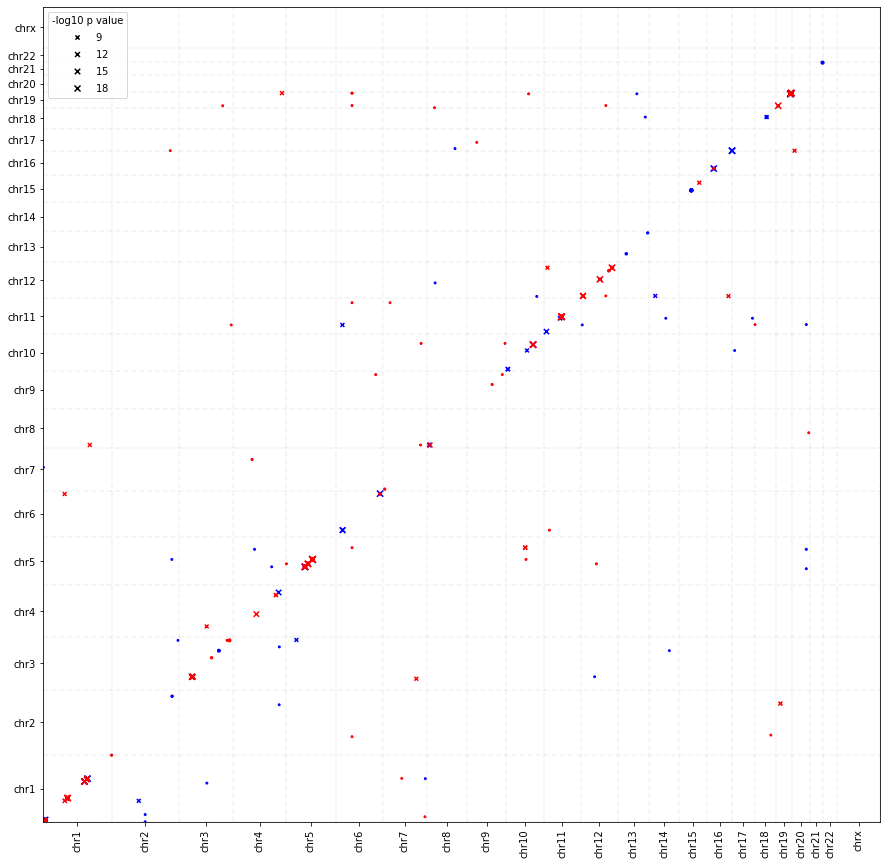

In [45]:

fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks(x_label_pos)
ax.set_xticklabels(x_labels)
ax.set_yticks(x_label_pos)
ax.set_yticklabels(x_labels)

for i in snps["color"].unique():
    snps_beta=snps[snps["color"]==i]
    for j in snps_beta["gwas"].unique():
        if j == "gwas":
            sc=ax.scatter(snps_beta[snps_beta["gwas"]==j]["adj bp"],snps_beta[snps_beta["gwas"]==j]["adj gene tx start"],s=snps_beta[snps_beta["gwas"]==j]["size"],color=i,label=i,marker="x")
        else:
            sc=ax.scatter(snps_beta[snps_beta["gwas"]==j]["adj bp"],snps_beta[snps_beta["gwas"]==j]["adj gene tx start"],s=snps_beta[snps_beta["gwas"]==j]["size"],color=i,label=i,marker=".")

for i in chrom_plot.values():
    plt.axhline(y=i,color="k",linestyle="--",alpha=0.05)
    plt.axvline(x=i,color="k",linestyle="--",alpha=0.05)
plt.ylim(0, 3036303846)
plt.xlim(0, 3036303846)
plt.xticks(rotation=90)
kw = dict(prop="sizes", num=5, color="k",
          func=lambda s: s/2)
plt.legend(*sc.legend_elements(**kw),
                    loc="upper left", title="-log10 p value")
plt.savefig("../plots/eqtl.grid.pdf", bbox_inches='tight')


## Plot manhattan section

In [46]:
brian=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/discovery/data/all/brian-tpm.compiled.lessthan.0001.GWAS.ADD",delimiter="\t",header=None)
firebrowse=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/discovery/data/all/firebrowse.compiled.lessthan.0001.GWAS.ADD",delimiter="\t",header=None)
pancan=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/discovery/data/all/pancanatlas.compiled.lessthan.0001.GWAS.ADD",delimiter="\t",header=None)


In [47]:
manhattan=brian.append(firebrowse)
manhattan=manhattan.append(pancan)

In [48]:
manhattan[0]="chr"+manhattan[0]

In [49]:
manhattan[0]=manhattan[0].str.lower()

In [50]:
manhattan[11]=np.where(manhattan[11]<10**-20,10**-20,manhattan[11])
manhattan["-log10"]=-np.log10(manhattan[11])

In [51]:
manhattan["chr start"]=manhattan[0].map(chrom_plot)

In [52]:
manhattan["adj bp"]=manhattan["chr start"]+manhattan[1]

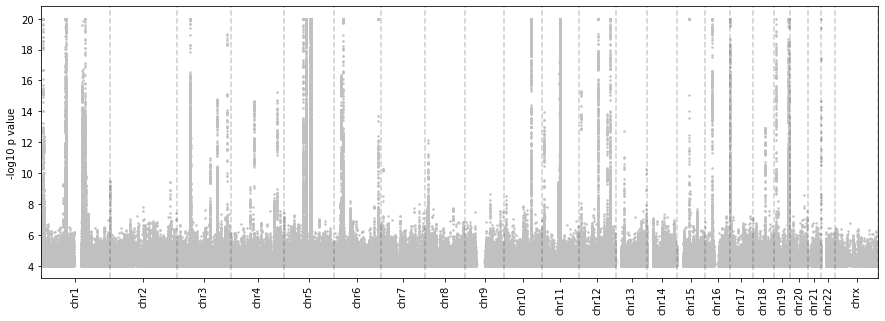

In [53]:
fig, ax = plt.subplots(figsize=(15,5))
plt.scatter(manhattan["adj bp"],manhattan["-log10"],s=2,color="silver")
plt.xlim(0, 3036303846)
for i in chrom_plot.values():
    plt.axvline(x=i,color="k",linestyle="--",alpha=0.2)
ax.set_xticks(x_label_pos)
ax.set_xticklabels(x_labels)
plt.xticks(rotation=90)
plt.ylabel("-log10 p value")
plt.savefig("../plots/eqtl.grid.manhattan.png", bbox_inches='tight')

In [54]:
labels=snps[["file","adj gene tx start"]]

In [55]:
labels_filt=labels[~labels["file"].duplicated()]

In [56]:
labels_filt=labels_filt[~(labels_filt["adj gene tx start"].isnull())]

In [57]:
counts=snps["file"].value_counts().reset_index()

In [58]:
counts_high=counts[counts["file"]>1]["index"].tolist()

In [59]:
labels_filt=labels_filt[labels_filt["file"].isin(counts_high)]

In [60]:
for i in labels_filt["adj gene tx start"]:
    if type(i) != float:
        print(i)

In [62]:
labels_filt.head()

,file,adj gene tx start
225,VAMP3,7.831328e+06
452,APITD1,1.049016e+07
368,DYNLT1,1.221599e+09
279,IFI44L,7.908609e+07
321,CCBL2,8.940146e+07


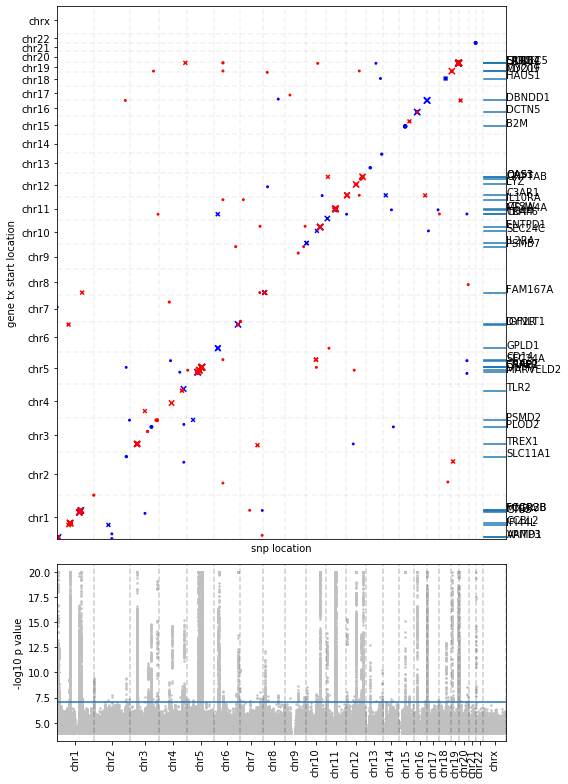

In [63]:
# plot it
fig = plt.figure(figsize=(8, 11)) 
gs = gridspec.GridSpec(2, 1, width_ratios=[1],height_ratios=[3,1]) 
ax0 = plt.subplot(gs[0])

for i in snps["color"].unique():
    snps_beta=snps[snps["color"]==i]
    for j in snps_beta["gwas"].unique():
        if j == "gwas":
            sc=ax0.scatter(snps_beta[snps_beta["gwas"]==j]["adj bp"],snps_beta[snps_beta["gwas"]==j]["adj gene tx start"],s=snps_beta[snps_beta["gwas"]==j]["size"],color=i,label=i,marker="x",rasterized=True)
        else:
            sc=ax0.scatter(snps_beta[snps_beta["gwas"]==j]["adj bp"],snps_beta[snps_beta["gwas"]==j]["adj gene tx start"],s=snps_beta[snps_beta["gwas"]==j]["size"],color=i,label=i,marker=".",rasterized=True)
for i in chrom_plot.values():
    ax0.axhline(y=i,color="k",linestyle="--",alpha=0.05)
    ax0.axvline(x=i,color="k",linestyle="--",alpha=0.05)
ax0.set_xticks([])
ax0.set_yticks(x_label_pos)
ax0.set_yticklabels(x_labels)

for i,row in labels_filt.iterrows():
    ax0.annotate(row["file"],(3036303846, int(row["adj gene tx start"])),fontsize=10)
    ax0.axhline(y=int(row["adj gene tx start"]), xmin=0.95, xmax=1.3)
    
plt.ylim(0, 3036303846)
plt.xlim(0, 3036303846)
plt.xlabel("snp location")
plt.ylabel("gene tx start location")
            
ax1 = plt.subplot(gs[1])
ax1.scatter(manhattan["adj bp"],manhattan["-log10"],s=2,color="silver",rasterized=True)

for i in chrom_plot.values():
    ax1.axvline(x=i,color="k",linestyle="--",alpha=0.2)
ax1.set_xticks(x_label_pos)
ax1.set_xticklabels(x_labels)

plt.xlim(0, 3036303846)
plt.xticks(rotation=90)
plt.ylabel("-log10 p value")
plt.axhline(7.1,)


plt.tight_layout()
plt.savefig('../plots/grid_figure.pdf',dpi=300)